# CNN - sponsorship model

Consider senate number 115, this notebook aims to predict votes profile for a bill using the sponsors' votes information.

Any other information on each senator can be encoded on a similarity graph.

In [110]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload

from lib import models_alt, graph, coarsening, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency.csv'

In [3]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [4]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [5]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return -1

In [6]:
votes_matrix=np.zeros((len(votes_115.vote_uri.unique()), N_SENATORS))

for i, l in enumerate(list(votes_115.vote_uri.unique())):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    votes_matrix[i] = feature

In [8]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [9]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,2,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,1,51,...,E000285,R,Sen.,passed,0,0,0,[],[],[]
3,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


Create binary matrices indicating sponsorship (and cosponsorship):

In [10]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

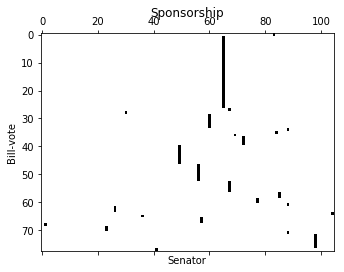

In [11]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [12]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

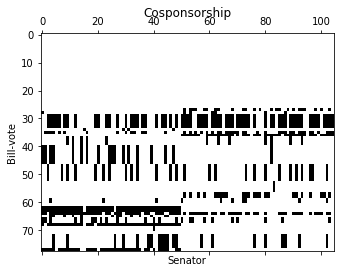

In [13]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [14]:
Z = S + CS # sponsorship mask

Get all votes for each bill-vote:

In [15]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

Use as feature vector the voting profile for each senator:

In [17]:
X = np.zeros((N_BILLS_SEN, N_SENATORS))
X[Z==1]=Y[Z==1]

In [18]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 78
d = 105


In [19]:
n_train = n//2
n_val = n//10

np.random.seed(321)
perm_idx = np.random.permutation(n)
X_train = X[perm_idx[:n_train]]
X_val = X[perm_idx[n_train:n_train+n_val]]
X_test = X[perm_idx[n_train+n_val:]]

y_train = Y[perm_idx[:n_train]]
y_val = Y[perm_idx[n_train:n_train+n_val]]
y_test = Y[perm_idx[n_train+n_val:]]


In [20]:
dist, idx = graph.distance_scipy_spatial(votes_matrix.T, k=20, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

d = |V| = 105, k|V| < |E| = 2996


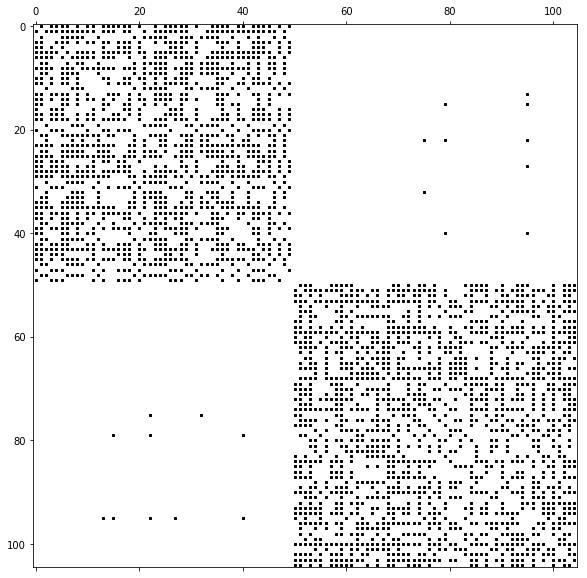

In [21]:
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [80]:
graphs, perm = coarsening.coarsen(A, levels=1, self_connections=False)

X_train_ = coarsening.perm_data(X_train, perm)
X_val_ = coarsening.perm_data(X_val, perm)
X_test_ = coarsening.perm_data(X_test, perm)
y_train_ = coarsening.perm_data(y_train, perm)
y_val_ = coarsening.perm_data(y_val, perm)
y_test_ = coarsening.perm_data(y_test, perm)

Layer 0: M_0 = |V| = 106 nodes (1 added),|E| = 1498 edges
Layer 1: M_1 = |V| = 53 nodes (0 added),|E| = 533 edges


In [81]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

## CNN

CNN model was adapted for performing regression instead of classification (see file model_alt.py).

In [94]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 200
params['batch_size']     = 10
params['eval_frequency'] = 40

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = L[0].shape[0]

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['p']              = [1, 1]  
params['M']              = [C]  # Output dimensionality of fully connected layers.
params['K']              = [4, 4]
         
# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = .1
params['decay_rate']     = 0.95
params['momentum']       = 0
params['decay_steps']    = n_train / params['batch_size']

Find optimal polynomial degree and learning rate (takes long):

In [26]:
# poly_vec = np.arange(1, 10)
# l_rate_vec = np.linspace(1e-2, 0.9, 20)
# VAL_ACC = np.zeros((len(poly_vec), len(l_rate_vec)))
# for i, k in enumerate(poly_vec):
#     for j, l in enumerate(l_rate_vec):
#         params['K'] = [k, k]
#         params['learning_rate']  = l 
#         model = models_alt.cgcnn(L, **params)
#         loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train_, y_train_, X_val_, y_val_, False)
#         VAL_ACC[i,j] = val_accs[-1]
        

In [27]:
val_acc_array = np.array(VAL_ACC)

In [28]:
ind_max = np.unravel_index(np.argmax(val_acc_array, axis=None), val_acc_array.shape)

In [37]:
print('Max validation accuracy: {:.2f} for a poly degree {:.2f} and a learning rate {:.2f}'.format(val_acc_array[ind_max], poly_vec[ind_max[0]], l_rate_vec[ind_max[0]]))

Max validation accuracy: 83.29 for a poly degree 2.00 and a learning rate 0.06


In [123]:
params['K'] = [2, 2]
params['learning_rate']  = 0.06
model = models_alt.cgcnn(L, **params)
loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train_, y_train_, X_val_, y_val_, True)

NN architecture
  input: M_0 = 106
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 106 * 32 / 1 = 3392
    weights: F_0 * F_1 * K_1 = 1 * 32 * 2 = 64
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 106 * 64 / 1 = 6784
    weights: F_1 * F_2 * K_2 = 32 * 64 * 2 = 4096
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 106
    weights: M_2 * M_3 = 6784 * 106 = 719104
    biases: M_3 = 106
step 40 / 780 (epoch 10.26 / 200):
  learning_rate = 3.78e-02, loss_average = 1.86e+00
  train loss: 1.79e+00, accuracy: 73.08
  validation loss: 2.67e+00, accuracy: 48.25
  time: 1s (wall 0s)
step 80 / 780 (epoch 20.51 / 200):
  learning_rate = 2.15e-02, loss_average = 1.54e+00
  train loss: 1.51e+00, accuracy: 74.58
  validation loss: 2.46e+00, accuracy: 43.13
  time: 3s (wall 1s)
step 120 / 780 (epoch 30.77 / 200):
  learning_rate = 1.29e-02, loss_average = 1.31e+00
  train loss: 1.28e+00, accuracy: 77.07
  validation loss: 2.12e+00, accuracy: 52.0

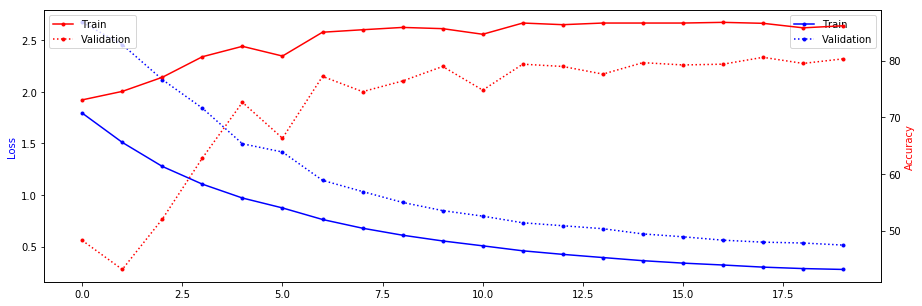

In [124]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_train, 'b.-')
ax1.set_ylabel('Loss', color='b')
ax1.plot(loss_val, 'b.:')
ax1.legend(['Train', 'Validation'])
ax2 = ax1.twinx()
ax2.plot(train_accs, 'r.-')
ax2.set_ylabel('Accuracy', color='r')
ax2.plot(val_accs, 'r.:')
ax2.legend(['Train', 'Validation'])

plt.show()

In [125]:
res = model.evaluate(X_test_, y_test_)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-780
loss: 5.53e-01, accuracy: 76.74
time: 0s (wall 0s)


In [126]:
def eval_prediction(Pred):
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

def accuracy(pred, truth):
    not_vot = np.not_equal(truth, 0)
    a = np.equal(pred, truth)
    acc=np.sum(a[not_vot])/np.size(truth[not_vot])
    return acc

In [127]:
Pred_train = model.predict(X_train_)
Pred_test = model.predict(X_test_)
Pred_train = eval_prediction(Pred_train)
Pred_test = eval_prediction(Pred_test)


INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-780
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-780


In [128]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['blue','white','red'])


Votes color:
- Red: Yes
- Blue: No


Text(0.5,1,'Training truth')

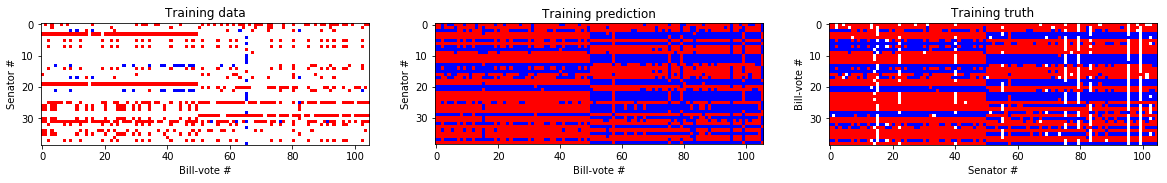

In [129]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred_train[:, np.argsort(perm)], vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')

In [130]:
print('Accuracy train: ', accuracy(Pred_train,y_train_))

Accuracy train:  0.9334381551362684


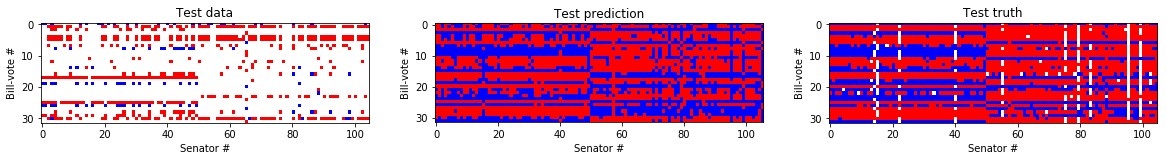

In [131]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test[:, np.argsort(perm)], vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

In [132]:
print('Accuracy test: ', accuracy(Pred_test,y_test_))

Accuracy test:  0.8264593908629442
